### Impotar librerias y definir variables globales

In [1]:
#Importar Librerias
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from IPython.display import Image
NOW = "29/02/2020"

### Definir la ruta base y leer los datos

In [31]:
mainpath = "/Users/jeanpierrevasquez/Documents/Proyecto/05.Segmentation_Customers/"
dataname = "Summary_data_V3.csv"
dataoutput = "RFM_Segmento_1002_to_2802"

fullpathdata = os.path.join(mainpath,dataname)
fullpathoutput = os.path.join(mainpath,dataoutput)

In [3]:
print(fullpathdata)
print(fullpathoutput)
print(NOW)

/Users/jeanpierrevasquez/Documents/Proyecto/05.Segmentation_Customers/Summary_data_V3.csv
/Users/jeanpierrevasquez/Documents/Proyecto/05.Segmentation_Customers/RFM_Segmento_1002_to_2802_V2.csv
29/02/2020


# Funciones de Apoyo

### Defenir Funciones de resta y formato de fechas 

In [4]:
def days_between(d1, d2):
  #  d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%d/%m/%Y")
    return abs((d2 - d1).days)

In [5]:
def format_date(d):
    return d[0:2] + "/"+ d[3:5] + "/2020"

### Definir las fuciones de Scores en base a los quintiles

In [6]:
def r_score(x,quintiles):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
def fm_score(x, c,quintiles):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

### Definir función para hallar el Score en base a los quintiles

In [7]:
def rfm_table_score(rfm_table,quintiles): 
    rfm_table['R'] = rfm_table['Recency'].apply(lambda x: r_score(x,quintiles))
    rfm_table['F'] = rfm_table['Frequency'].apply(lambda x: fm_score(x, 'Frequency',quintiles))
    rfm_table['M'] = rfm_table['Monetary'].apply(lambda x: fm_score(x, 'Monetary',quintiles))
    rfm_table['RFM Score'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)
    return rfm_table

### Definir función para hallar los segmentos

In [8]:
def rfm_table_segment(rfm_table,segt_map,segt_other):
    rfm_table['Segment'] = rfm_table['RFM Score']
    rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
    rfm_table['Segment'] = rfm_table['Segment'].replace(segt_other, regex=True)
    return rfm_table

### Los Segmentos del RFM y las REGLAS son los siguientes : 

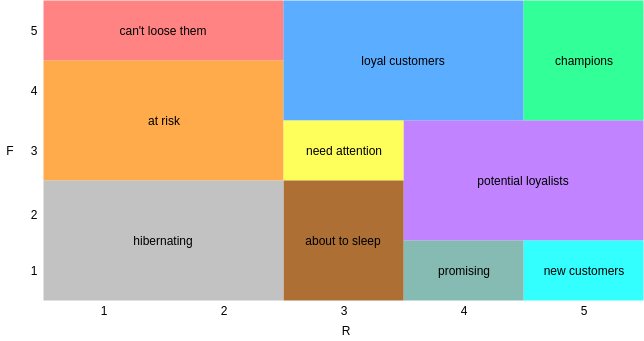

In [9]:
Image(filename='rfm-segments.png')

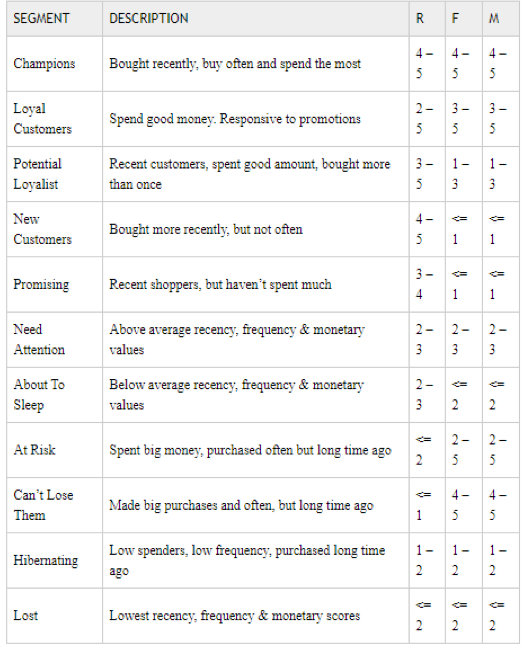

In [10]:
Image(filename='RFM_Rules.png',width=400,height=60)

In [11]:
segt_map = {
    r'[4-5][4-5][4-5]': 'A. Champions',
    r'[2-5][3-5][3-5]': 'B. Loyal Customers',
    r'[3-5][1-3][1-3]': 'C. Potential Loyalist',
    r'[4-5]11': 'D. New Customers',
    r'[3-4]11': 'E. Promising',
    r'[2-3][2-3][2-3]': 'F. Need Attention',
    r'[2-3][1-2][1-2]': 'G. About to Sleep',
    r'[1-2][2-5][2-5]': 'H. At Risk',
    r'1[4-5][4-5]': 'I. Can\'t Lose Them',
    r'[1-2][1-2][1-2]': 'J. Hibernating',
    r'55[1-2]': 'K. Outlier',
    r'11[4-5]': 'K. Outlier'
}

segt_other={r'[0-9]+':'L. Others'}

# Lógica de Clustering

### Estructurar la data , leemos la data que descargamos del libro summary (todas las transacciones)

In [12]:
data_all = pd.read_csv(fullpathdata,sep=",")
data_all.head(10)

/Users/jeanpierrevasquez/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,16,31,33,34,35,43,54,63,66,67,68,71,87,94,99,128,130,142,143,144,147,149,151,153) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#Trips Out Of GeoFence,%Utilization over Scooters Deployed,Cabify Avg. Duration (mins),Blank 2,Blank 3,Blank 4,Cabify Fee,Cabify Avg. Ticket,%Utilization over Total Fleet,New Users w/Discount,...,trip_region,trips_order,type,updated_at,usd_xr,user_registration_date,vehicleid,zone_end,zone_final,zone_start
0,1,54%,NaN,NaN,NaN,NaN,0,NaN,257300%,1,...,Lima,1.0,kick,02/23/2020 22:51:57,0.294955,02/23/2020 22:37:44,movo-scooter:19707,NaN,PER-LIM-F,PER-LIM-F
1,0,67%,NaN,NaN,NaN,NaN,0,NaN,334800%,0,...,Lima,32.0,kick,02/27/2020 18:28:02,0.294955,08/13/2019 19:05:31,movo-scooter:17974,PER-LIM-B,PER-LIM-C,PER-LIM-C
2,0,67%,NaN,NaN,NaN,NaN,0,NaN,331800%,0,...,Lima,39.0,kick,02/19/2020 14:20:45,0.294955,12/23/2019 18:08:32,movo-scooter:18285,PER-LIM-D,PER-LIM-E,PER-LIM-E
3,0,99%,NaN,NaN,NaN,NaN,0,NaN,295000%,0,...,Lima,29.0,kick,2/12/20 19:38,0.294955,12/23/2019 18:08:32,movo-scooter:14694,PER-LIM-E,NaN,NaN
4,0,54%,NaN,NaN,NaN,NaN,0,NaN,243100%,0,...,Lima,33.0,kick,02/16/2020 16:13:17,0.294955,12/23/2019 18:08:32,movo-scooter:14331,PER-LIM-E,PER-LIM-E,PER-LIM-E
5,0,72%,NaN,NaN,NaN,NaN,0,NaN,333300%,0,...,Lima,32.0,kick,02/14/2020 18:56:47,0.294955,12/23/2019 18:08:32,movo-scooter:14766,PER-LIM-D,PER-LIM-D,PER-LIM-D
6,0,66%,NaN,NaN,NaN,NaN,0,NaN,321400%,0,...,Lima,35.0,kick,02/18/2020 14:21:09,0.294955,12/23/2019 18:08:32,movo-scooter:19616,PER-LIM-D,PER-LIM-E,PER-LIM-E
7,0,70%,NaN,NaN,NaN,NaN,0,NaN,304600%,0,...,Lima,30.0,kick,02/13/2020 14:08:03,0.294955,12/23/2019 18:08:32,movo-scooter:8674,PER-LIM-D,PER-LIM-E,PER-LIM-E
8,0,63%,NaN,NaN,NaN,NaN,0,NaN,306900%,0,...,Lima,34.0,kick,02/17/2020 19:57:54,0.294955,12/23/2019 18:08:32,movo-scooter:8700,PER-LIM-E,PER-LIM-E,PER-LIM-E
9,0,65%,NaN,NaN,NaN,NaN,0,NaN,295000%,0,...,Lima,27.0,kick,2/11/20 13:59,0.294955,12/23/2019 18:08:32,movo-scooter:8877,PER-LIM-D,PER-LIM-E,PER-LIM-E


In [13]:
data_all.columns

Index(['#Trips Out Of GeoFence', '%Utilization over Scooters Deployed',
       'Cabify Avg. Duration (mins)', 'Blank 2', 'Blank 3', 'Blank 4',
       'Cabify Fee', 'Cabify Avg. Ticket', '%Utilization over Total Fleet',
       'New Users w/Discount',
       ...
       'trip_region', 'trips_order', 'type', 'updated_at', 'usd_xr',
       'user_registration_date', 'vehicleid', 'zone_end', 'zone_final',
       'zone_start'],
      dtype='object', length=154)

### Filtramos las columnas necesarias para el cluster
#### UserId -> Identificador único del usuario 
#### region_final -> Ciudad 
#### #Trips -> Variable de trip 
#### GMV - Rectifications -> GMV en dolares 
#### Time -> Fecha de la transacción
#### Active Users -> Identificador si el usuario es activo con nuestro producto
#### Type -> Tipo de Asset

In [14]:
columns_table = ["UserId", "region_final", "#Trips","GMV - Rectifications","Time","Active Users","type"]
row_filter = data_all["Active Users"]==1
data_reduce = data_all[row_filter][columns_table]
data_reduce.head(10)

,UserId,region_final,#Trips,GMV - Rectifications,Time,Active Users,type
0,2Hire:960785,Lima,1,17.106080,23/02/20,1,kick
1,2Hire:432187,Lima,1,0.884864,27/02/20,1,kick
2,2Hire:867536,Lima,1,1.476131,19/02/20,1,kick
3,2Hire:867536,Lima,1,1.474774,12/02/20,1,kick
4,2Hire:867536,Lima,1,2.654593,16/02/20,1,kick
5,2Hire:867536,Lima,1,0.589910,14/02/20,1,kick
6,2Hire:867536,Lima,1,1.474774,18/02/20,1,kick
7,2Hire:867536,Lima,1,1.327297,13/02/20,1,kick
8,2Hire:867536,Lima,1,1.918563,17/02/20,1,kick
9,2Hire:867536,Lima,1,1.327297,11/02/20,1,kick


In [15]:
data_reduce["Fecha"] = data_reduce["Time"].apply(lambda x: format_date(x))
data_reduce.head(5)

,UserId,region_final,#Trips,GMV - Rectifications,Time,Active Users,type,Fecha
0,2Hire:960785,Lima,1,17.106080,23/02/20,1,kick,23/02/2020
1,2Hire:432187,Lima,1,0.884864,27/02/20,1,kick,27/02/2020
2,2Hire:867536,Lima,1,1.476131,19/02/20,1,kick,19/02/2020
3,2Hire:867536,Lima,1,1.474774,12/02/20,1,kick,12/02/2020
4,2Hire:867536,Lima,1,2.654593,16/02/20,1,kick,16/02/2020


In [16]:
data_reduce["Fecha_"] = data_reduce["Fecha"].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
data_reduce.head(5)

,UserId,region_final,#Trips,GMV - Rectifications,Time,Active Users,type,Fecha,Fecha_
0,2Hire:960785,Lima,1,17.106080,23/02/20,1,kick,23/02/2020,2020-02-23
1,2Hire:432187,Lima,1,0.884864,27/02/20,1,kick,27/02/2020,2020-02-27
2,2Hire:867536,Lima,1,1.476131,19/02/20,1,kick,19/02/2020,2020-02-19
3,2Hire:867536,Lima,1,1.474774,12/02/20,1,kick,12/02/2020,2020-02-12
4,2Hire:867536,Lima,1,2.654593,16/02/20,1,kick,16/02/2020,2020-02-16


### Definirmos el RFM Table : Frequency,Monetary y Recency

In [17]:
rfm_table_global = data_reduce.groupby(['UserId','region_final',"type"]).agg({
        'Fecha_': lambda x: x.max(),
        '#Trips': 'count',
        'GMV - Rectifications': 'sum'}).reset_index()
rfm_table_global.rename(columns={ 'region_final':'Region',
                         'Fecha_':"Fecha",
                         '#Trips': 'Frequency',
                         'GMV - Rectifications': 'Monetary'}, inplace=True)
rfm_table_global["Recency"] = rfm_table_global["Fecha"].apply(lambda x: days_between(x,NOW))
rfm_table_global.head(10)

,UserId,Region,type,Fecha,Frequency,Monetary,Recency
0,2Hire:100166,Lima,kick,2020-02-10,1,1.179819,19
1,2Hire:100243,Lima,kick,2020-02-28,16,14.453021,1
2,2Hire:100670,Lima,kick,2020-02-12,5,11.798723,17
3,2Hire:100690,Lima,kick,2020-02-23,1,3.095728,6
4,2Hire:100828,Lima,kick,2020-02-19,1,1.179819,10
5,2Hire:100927,Lima,kick,2020-02-12,1,0.884864,17
6,2Hire:100934,Lima,kick,2020-02-28,12,31.110003,1
7,2Hire:100943,Lima,kick,2020-02-21,1,1.032342,8
8,2Hire:101267,Lima,kick,2020-02-26,5,6.346601,3
9,2Hire:101453,Lima,kick,2020-02-21,2,3.686935,8


In [18]:
columns_table = ["Region", "type"]
data_type = rfm_table_global[columns_table]
data_type_asset = data_type.drop_duplicates(['Region','type']).reset_index()
data_type_asset.head(10)

,index,Region,type
0,0,Lima,kick
1,334,Buenos Aires,kick


In [32]:
columns_table = ["UserId", "Frequency", "Monetary","Recency","Fecha","Region","type"]
for index,dts in data_type_asset.iterrows():
    print("----------------------------------------Inicio----------------------------")
    print( dts["Region"] + " - " + dts["type"] )
    filter_region = rfm_table_global["Region"] == dts["Region"]
    filter_asset = rfm_table_global["type"] == dts["type"]
    rfm_table_regional = rfm_table_global[filter_region & filter_asset][columns_table]
    print(rfm_table_regional)
    print(rfm_table_regional.describe())
    quintiles_regional = rfm_table_regional[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
    print(quintiles_regional)
    rfm_table_regional = rfm_table_score(rfm_table_regional,quintiles_regional)
    rfm_table_regional = rfm_table_segment(rfm_table_regional,segt_map,segt_other)
    print(rfm_table_regional)
    rfm_table_regional.to_csv(mainpath +dataoutput+ "_" +dts["Region"] +"_"+ dts["type"] + ".csv")
    print("----------------------------------------Fin------------------------------")

----------------------------------------Inicio----------------------------
Lima - kick
             UserId  Frequency   Monetary  Recency      Fecha Region  type
0      2Hire:100166          1   1.179819       19 2020-02-10   Lima  kick
1      2Hire:100243         16  14.453021        1 2020-02-28   Lima  kick
2      2Hire:100670          5  11.798723       17 2020-02-12   Lima  kick
3      2Hire:100690          1   3.095728        6 2020-02-23   Lima  kick
4      2Hire:100828          1   1.179819       10 2020-02-19   Lima  kick
...             ...        ...        ...      ...        ...    ...   ...
22161   2Hire:99606          1   2.654593       11 2020-02-18   Lima  kick
22162   2Hire:99633          5  20.643355        4 2020-02-25   Lima  kick
22163   2Hire:99681         11  18.137655        2 2020-02-27   Lima  kick
22164   2Hire:99828         11  19.026354        1 2020-02-28   Lima  kick
22165   2Hire:99834          1   1.621897       13 2020-02-16   Lima  kick

[17252 rows 

Inciar de aca con graficos para una ciudad y un tipo de asset .....

In [78]:
city = "Lima"
asset = "kick"
filter_region = rfm_table_global["Region"] == city
filter_asset = rfm_table_global["type"] == asset
columns_table = ["UserId","Recency", "Frequency", "Monetary","Fecha","Region","type"]
rfm_table_analysis = rfm_table_global[filter_region & filter_asset][columns_table]
rfm_table_analysis.shape

(17252, 7)

### Descripción general de los datos  e Histogramas 

In [79]:
rfm_table_analysis.describe()

,Recency,Frequency,Monetary
count,17252.000000,17252.000000,17252.000000
mean,7.788141,3.163401,6.327241
std,5.540376,4.297501,8.461651
min,1.000000,1.000000,-0.003480
25%,3.000000,1.000000,1.622251
50%,7.000000,2.000000,3.244503
75%,12.000000,3.000000,7.372572
max,19.000000,68.000000,170.479980


Text(0.5, 1.0, 'Histograma de Frequency de Lima - kick')

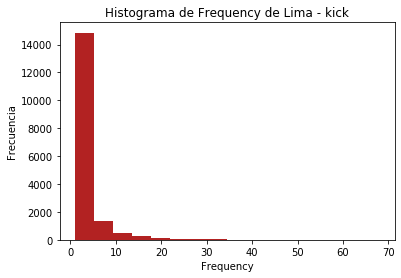

In [48]:
k = int(np.ceil(1+np.log2(18000)))
plt.hist(rfm_table_analysis["Frequency"],bins= k, color="firebrick")
plt.xlabel("Frequency")
plt.ylabel("Frecuencia")
plt.title("Histograma de Frequency de " + city +" - " + asset )

Text(0.5, 1.0, 'Histograma de Monetary Lima - kick')

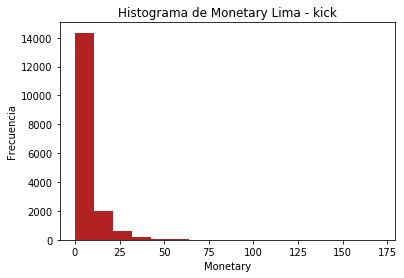

In [49]:
plt.hist(rfm_table_analysis["Monetary"],bins= k, color="firebrick")
plt.xlabel("Monetary")
plt.ylabel("Frecuencia")
plt.title("Histograma de Monetary " + city +" - " + asset )

Text(0.5, 1.0, 'Histograma de RecencyLima - kick')

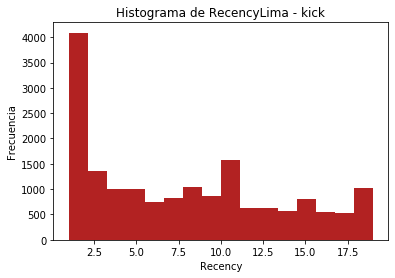

In [50]:
plt.hist(rfm_table_analysis["Recency"],bins= k, color="firebrick")
plt.xlabel("Recency")
plt.ylabel("Frecuencia")
plt.title("Histograma de Recency" + city +" - " + asset )

### Definimos los quintiles de las variles Frequency,Monetary y Recency 

In [77]:
quintiles_analysis = rfm_table_analysis[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles_analysis_df = pd.DataFrame(quintiles_analysis)
quintiles_analysis_df.head(15)

,Recency,Frequency,Monetary
0.2,2.0,1.0,1.473476
0.4,5.0,1.0,2.505464
0.6,9.0,2.0,4.276845
0.8,14.0,4.0,9.142148


### Hallamos el RFM & Score GLOBAL

In [76]:
rfm_table_analysis = rfm_table_score(rfm_table_analysis,quintiles_analysis)
rfm_table_analysis.head(5)

,UserId,Frequency,Monetary,Recency,Fecha,Region,type,R,F,M,RFM Score,Segment
0,2Hire:100166,1,1.179819,19,2020-02-10,Lima,kick,1,1,1,111,J. Hibernating
1,2Hire:100243,16,14.453021,1,2020-02-28,Lima,kick,5,5,5,555,A. Champions
2,2Hire:100670,5,11.798723,17,2020-02-12,Lima,kick,1,5,5,155,H. At Risk
3,2Hire:100690,1,3.095728,6,2020-02-23,Lima,kick,3,1,3,313,C. Potential Loyalist
4,2Hire:100828,1,1.179819,10,2020-02-19,Lima,kick,2,1,1,211,G. About to Sleep


### Asignamos el Segmento GLOBAL segun las reglas 

In [53]:
rfm_table_analysis = rfm_table_segment(rfm_table_analysis,segt_map,segt_other)
rfm_table_analysis.head(5)

,UserId,Frequency,Monetary,Recency,Fecha,Region,type,R,F,M,RFM Score,Segment
0,2Hire:100166,1,1.179819,19,2020-02-10,Lima,kick,1,1,1,111,J. Hibernating
1,2Hire:100243,16,14.453021,1,2020-02-28,Lima,kick,5,5,5,555,A. Champions
2,2Hire:100670,5,11.798723,17,2020-02-12,Lima,kick,1,5,5,155,H. At Risk
3,2Hire:100690,1,3.095728,6,2020-02-23,Lima,kick,3,1,3,313,C. Potential Loyalist
4,2Hire:100828,1,1.179819,10,2020-02-19,Lima,kick,2,1,1,211,G. About to Sleep


### Escribimos el archivo con los resultados

In [170]:
rfm_table_analysis.to_csv(fullpathoutput)

### Distribución por Segmentos

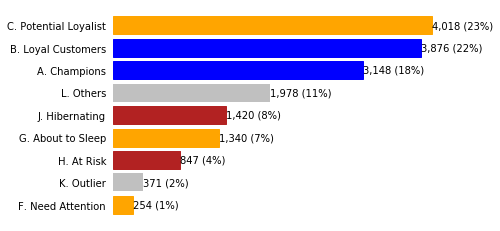

In [65]:
segments_counts = rfm_table_analysis['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['A. Champions', 'B. Loyal Customers']:
            bar.set_color('blue')
        if segments_counts.index[i] in ['C. Potential Loyalist', 'F. Need Attention',"G. About to Sleep"]:
            bar.set_color('orange')
        if segments_counts.index[i] in ['J. Hibernating', 'H. At Risk']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

### Distribución de Frequency,Monetary y Recency

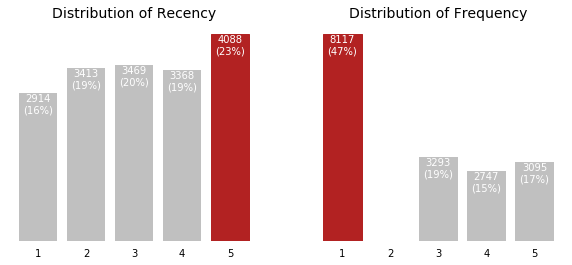

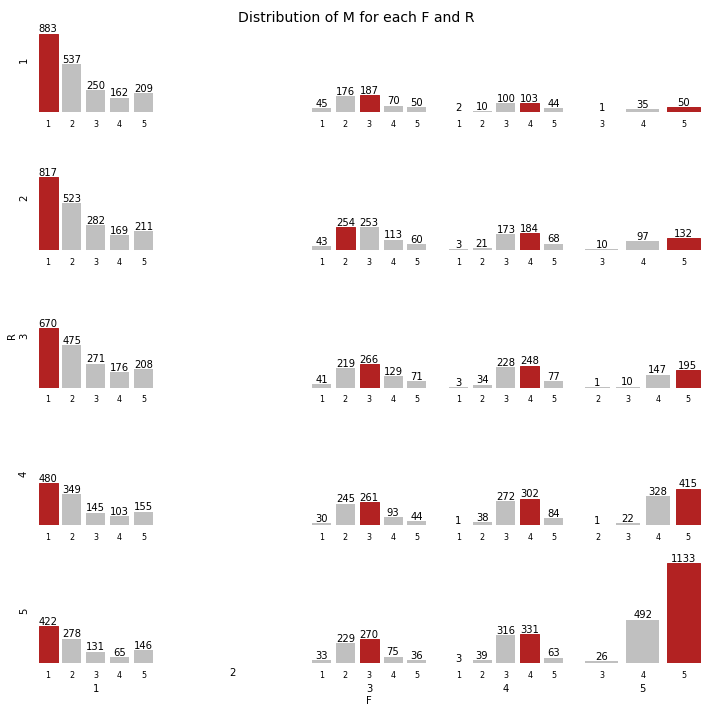

In [61]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm_table_analysis[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm_table_analysis[(rfm_table_analysis['R'] == r) & (rfm_table_analysis['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()